# NRDT simplified (spectogram aiming to replace MFCC with reduced complexity) 
# A transform with 16 code lines proved so far a convenient replacement of more sofisticated transforms (e.g.MFCCs) for various signal recognition problems.
# Particularly useful for HW-oriented devices (MCU, FPGAs) in the Tiny-ML context 


Copyright Radu DOGARU radu.dogaru@upb.ro 
Last update 20 July 2025 

For facile access to datasets run on Kaggle (for dataset access)

**Relevant papers (please cite)**

[1] R. Dogaru and I. Dogaru, "A low complexity solution for epilepsy detection using an improved version of the reaction-diffusion transform," 2017 5th International Symposium on Electrical and Electronics Engineering (ISEEE), Galati, Romania, 2017, pp. 1-6, doi: 10.1109/ISEEE.2017.8170678.
https://ieeexplore.ieee.org/document/8170678 

[2] R. Dogaru and I. Dogaru, "State of the Art Recognition of Emotions from Speech, Using a Low Complexity Solution Based on Reaction-Diffusion Transform," 2022 International Symposium on Electronics and Telecommunications (ISETC), Timisoara, Romania, 2022, pp. 1-4, doi: 10.1109/ISETC56213.2022.10010234. 
https://ieeexplore.ieee.org/document/10010234

In [1]:
import numpy as np 
import librosa 

def nrdt_2025(signal, M=8, w=256, chan=[1,2,4,8, 16, 32, 64, 100]):
    m = len(chan)  # number of delays (a.k.a. filter banks )
    windows=len(signal)//w
    Samples= w*windows 
    Feat_spec = np.zeros((M,m))
    matrix = np.reshape(signal[0:Samples],(windows,w)) # working matrix - each line is a w-sized window from signal 
    spectrum = np.zeros((windows,m))  # initialize spectrum lines 
    for i in range(0,windows): # Compute the RDT "spectrum for each window "
        for k in range(0,m): 
            delay=chan[k]  
            t=np.array(range(delay,w-delay-1)) 
            difus=np.abs(matrix[i,t-delay]+matrix[i,t+delay]-2*matrix[i,t]) 
            spectrum[i,k]=np.mean(difus)/4  
    # Given the M analysis segments - compute average (sum) of spectrums per each segment 
    fer_per_segment=windows // M 
    for k in range(0,M):
            Feat_spec[k,:]=np.sum(spectrum[k*fer_per_segment:((k+1)*fer_per_segment),:],axis=0) 
    return Feat_spec

# Usage examples 

In [63]:
ptt='/kaggle/input/bonn-eeg-dataset/Bonn Univeristy Dataset/O/O005.txt'
signal = np.loadtxt(ptt)
signal.shape
feat=nrdt_2025(signal, M=8, w=128, chan=[4,6,12,24,40,50])

In [64]:
feat.astype('int16')

array([[ 94, 144,  92, 143, 135, 131],
       [ 93, 138,  72, 117, 105, 113],
       [ 90, 137,  93, 136, 125,  91],
       [118, 179,  99, 170, 163, 122],
       [ 71, 103,  75, 114, 109,  87],
       [ 66,  92,  67,  89,  86,  71],
       [ 86, 129,  95, 138, 123, 105],
       [ 74, 111,  89, 110, 100,  92]], dtype=int16)

In [65]:
pth = '/kaggle/input/emo-db-refined/Emo-DB-refined/Happy/03a01Fa.wav'
signal, sr=librosa.load(pth,sr=16000)   # optim pentru incarcat in formatul (N,)
import time as ti

t1=ti.time()
feat=nrdt_2025(signal, M=8, w=256, chan=[1,2,4,8,16,32,64])
t2=ti.time()
print('Duration of NRDT transform: ',t2-t1,'seconds for ',len(signal),' samples')

# producing a similar size MFCC spectrogram 
# in comparing times, note that MFCC computations (FFT, DCT etc.) are likely to be optimized for CPU processors, while RDT is not 
# RDT is better suited for TinyML devices (e.g. requiring no multipliers, finite precision etc.)
t1=ti.time()
feat2 = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=7, n_fft=4096*4, hop_length=4*1024).T
t2=ti.time()
print('Duration of MFCC transform: ',t2-t1,'seconds for ',len(signal),' samples')

Duration of NRDT transform:  0.0419459342956543 seconds for  30372  samples
Duration of MFCC transform:  0.0497889518737793 seconds for  30372  samples


Text(0.5, 1.0, 'MFCC spectrogram')

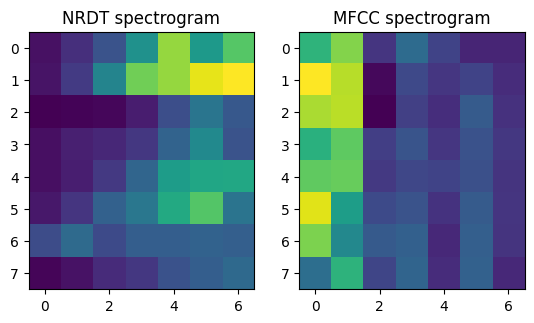

In [66]:
import matplotlib.pyplot as plt
feat.shape
#print((feat*256).astype('int16'))
plt.subplot(1,2,1); plt.imshow(feat); plt.title('NRDT spectrogram')
plt.subplot(1,2,2); plt.imshow(feat2); plt.title('MFCC spectrogram')